In [1]:
# 3rd Party dependencies.
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms.v2 as transforms

from torch.utils.data import DataLoader
from tqdm import tqdm

# 1st Party dependencies.
from dataset.facades_dataset import FacadesDataset
from pix2pix.generator import UnetGenerator, GeneratorLoss
from pix2pix.discriminator import ConditionalDiscriminator, DiscriminatorLoss

%matplotlib inline

In [2]:
# Default transforms are noted in the original paper
# in paragraph 6.2 as "Random jitter".
# The experiment is called "Cityscapes labels→photo".
train_transforms = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    # Resizing the 256×256 input images to 286×286.
    transforms.Resize((286, 286)), 
    # Randomly cropping back to size 256×256.
    transforms.RandomCrop(256),
    # Mirroring.
    transforms.RandomHorizontalFlip(),
])

default_transforms = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
])

In [3]:
facades_train_dataset = FacadesDataset(root_dir='dataset/facades', split='train', transformations=train_transforms)
facades_test_dataset = FacadesDataset(root_dir='dataset/facades', split='test', transformations=default_transforms)
facades_val_dataset = FacadesDataset(root_dir='dataset/facades', split='val', transformations=default_transforms)

train_dataloader = DataLoader(facades_train_dataset, batch_size=1, shuffle=True)

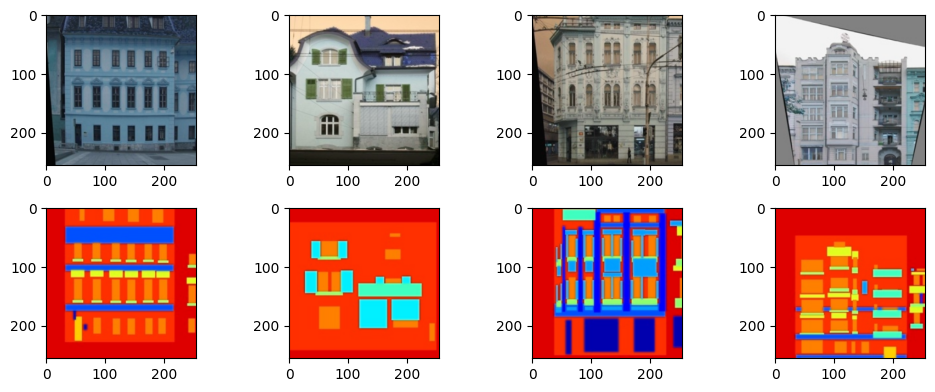

In [4]:
def visualise_dataset(dataset, indexes):
    figure, ax = plt.subplots(nrows=2, ncols=len(indexes), figsize=(10, 4))
    
    for i, idx in enumerate(indexes):
        image, label = dataset[idx]
        image = np.transpose(image, (1,2,0))
        label = np.transpose(label, (1,2,0))
        
        ax[0, i].imshow(image)
        ax[1, i].imshow(label)
    plt.tight_layout(pad=1)
    plt.show()    

visualise_dataset(facades_train_dataset, np.random.choice(range(len(facades_train_dataset)), 4))

In [ ]:
# Setup.
device = ('cuda' if torch.cuda.is_available() else 'cpu')
learning_rate = 0.0002
epochs = 200

generator = UnetGenerator().to(device)
discriminator = ConditionalDiscriminator().to(device)

# optimizers
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# loss functions
generator_loss = GeneratorLoss(alpha=100)
discriminator_loss = DiscriminatorLoss()

generator_history = []
discriminator_history = []

for epoch in range(epochs):

    generator_losses = []
    discriminator_losses = []

    for real, condition in tqdm(train_dataloader):        
        condition = condition.to(device)
        real = real.to(device)

        # Generator's loss.
        fake = generator(condition)
        fake_pred = discriminator(fake, condition)
        gl = generator_loss(fake, real, fake_pred)

        # Discriminator's loss.
        fake = generator(condition).detach()
        fake_pred = discriminator(fake, condition)
        real_pred = discriminator(real, condition)
        dl = discriminator_loss(fake_pred, real_pred)

        # Generator`s params update
        generator_optimizer.zero_grad()
        gl.backward()
        generator_optimizer.step()

        # Discriminator`s params update
        discriminator_optimizer.zero_grad()
        dl.backward()
        discriminator_optimizer.step()

        # add batch losses
        generator_losses.append(gl.item())
        discriminator_losses.append(dl.item())

    epoch_g_loss = np.mean(generator_losses)
    epoch_d_loss = np.mean(discriminator_losses)
    
    generator_history.append(epoch_g_loss)
    discriminator_history.append(epoch_d_loss)

    print('Epoch:', epoch, 'generator loss:', epoch_g_loss, 'discriminator loss:', epoch_d_loss)

    torch.save(generator.state_dict(), f"generator-{epoch:03d}-{epoch_g_loss:.3f}.pt")
    torch.save(discriminator.state_dict(), f"discriminator-{epoch:03d}-{epoch_g_loss:.3f}.pt")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:26<00:00,  4.61it/s]


Epoch: 0 generator loss: 23.927708230018617 discriminator loss: 0.17700482467014808


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 317/400 [01:09<00:17,  4.63it/s]